# ML notebook: Diabetes dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report, ConfusionMatrixDisplay, auc
from sklearn.model_selection import GridSearchCV
from sklearn import metrics



from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier



In [2]:
# loading dataset
df = pd.read_csv("cleaned_diabetes_dataset_2.csv")

In [3]:
df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,sleep_hours_per_day,...,bmi,systolic_bp,diastolic_bp,heart_rate,hdl_cholesterol,ldl_cholesterol,triglycerides,insulin_level,hba1c,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,7.9,...,30.5,134,78,68,41,160,145,6.36,8.18,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.5,...,23.1,129,76,67,55,50,30,2.00,5.63,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,10.0,...,22.2,115,73,74,66,99,36,5.07,7.51,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,6.6,...,26.8,120,93,68,50,79,140,5.28,9.03,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.4,...,21.2,92,67,67,52,125,160,12.74,7.20,1


In [4]:
# viewing the column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 100000 non-null  int64  
 1   gender                              100000 non-null  object 
 2   ethnicity                           100000 non-null  object 
 3   education_level                     100000 non-null  object 
 4   income_level                        100000 non-null  object 
 5   employment_status                   100000 non-null  object 
 6   smoking_status                      100000 non-null  object 
 7   alcohol_consumption_per_week        100000 non-null  int64  
 8   physical_activity_minutes_per_week  100000 non-null  int64  
 9   sleep_hours_per_day                 100000 non-null  float64
 10  screen_time_hours_per_day           100000 non-null  float64
 11  family_history_diabetes    

## Train-test split the data

In [5]:
# Train-test split data first to avoid data leakage
y = df['diagnosed_diabetes'] 
X = df.drop('diagnosed_diabetes', axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y,                
                                                    test_size=0.2,       
                                                    random_state=42)

I will be creating two models for this project. One model will simplified as not everyone will have access to certain medical information such as 'heart rate' or 'total cholesterol'. The second model will contain all information, including medical information.

In [6]:
# Creating the two models 

min_model = ['age', 
            "gender",
            "ethnicity",
            "education_level",
            "income_level",
            "employment_status",
            "smoking_status",
            "alcohol_consumption_per_week",
            "physical_activity_minutes_per_week",
            "sleep_hours_per_day",
            "screen_time_hours_per_day",
            "family_history_diabetes",
            "hypertension_history",
            "cardiovascular_history",
            "bmi",
            "systolic_bp",
            "diastolic_bp"]

max_model = X.columns.tolist()

In [7]:
X_train_min = X_train[min_model].copy()
X_test_min  = X_test[min_model].copy()

X_train_max = X_train[max_model].copy()
X_test_max  = X_test[max_model].copy()

### Feature Engineering

In [8]:
# Mapping on ordinal data
multi_mapping = {
                'education_level': {'No formal':0, 'Highschool':1,'Graduate':2,'Postgraduate':3},
                'income_level': {'Low':0, 'Lower-Middle':1, 'Middle':2, 'Upper-Middle':3, 'High':4} }

for col, mapping in multi_mapping.items():
    X_train_min[col] = X_train_min[col].map(mapping)
    X_test_min[col] = X_test_min[col].map(mapping)
    X_train_max[col] = X_train_max[col].map(mapping)
    X_test_max[col] = X_test_max[col].map(mapping)

In [9]:
# # One-hot encoding (OHE) for multi-level categories
multi_OHE = ['gender','ethnicity','employment_status','smoking_status']

# OHE train data
X_train_min = pd.get_dummies(X_train_min, columns=multi_OHE, dtype=int)
X_train_max = pd.get_dummies(X_train_max, columns=multi_OHE, dtype=int)

#OHE test data
X_test_min = pd.get_dummies(X_test_min, columns=multi_OHE, dtype=int)
X_test_max = pd.get_dummies(X_test_max, columns=multi_OHE, dtype=int)

print(X_train_min.shape)
print(X_test_min.shape)
print(X_train_max.shape)
print(X_test_max.shape)

# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data

(80000, 28)
(20000, 28)
(80000, 34)
(20000, 34)


### Scaling

In [11]:
# Selecting numerical columns for min/max model for scaling
min_numerical_cols = ['age',
                  'alcohol_consumption_per_week',
                  'physical_activity_minutes_per_week',
                  'sleep_hours_per_day',
                  'screen_time_hours_per_day',
                  'bmi',
                  'systolic_bp',
                  'diastolic_bp']

max_numerical_cols = ['age',
                  'alcohol_consumption_per_week',
                  'physical_activity_minutes_per_week',
                  'sleep_hours_per_day',
                  'screen_time_hours_per_day',
                  'bmi',
                  'systolic_bp',
                  'diastolic_bp',
                  'heart_rate',
                  'hdl_cholesterol',
                  'ldl_cholesterol',
                  'triglycerides',
                  'insulin_level',
                  'hba1c']

##numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
##newdf = df.select_dtypes(include=numerics)

In [12]:
# Minimal model scaling
z_min = StandardScaler()

# Fit scaler onto min model training data
z_min.fit(X_train_min[min_numerical_cols])
# Scaling train data
X_train_min_scaled = X_train_min.copy()
X_train_min_scaled[min_numerical_cols] = z_min.transform(X_train_min_scaled[min_numerical_cols])
# Scaling test data
X_test_min_scaled = X_test_min.copy()
X_test_min_scaled[min_numerical_cols] = z_min.transform(X_test_min_scaled[min_numerical_cols])

In [13]:
# Maximum model scaling
z_max = StandardScaler()

# Fit scaler onto max model training data
z_max.fit(X_train_max[max_numerical_cols])
# Scaling train data
X_train_max_scaled = X_train_max.copy()
X_train_max_scaled[max_numerical_cols] = z_max.transform(X_train_max_scaled[max_numerical_cols])
# Scaling test data
X_test_max_scaled = X_test_max.copy()
X_test_max_scaled[max_numerical_cols] = z_max.transform(X_test_max_scaled[max_numerical_cols])


# Training the models

## Training min model

In [16]:
# Models list
min_models = {
    'Logistic Regression': LogisticRegression(max_iter=15000),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='auc'
    )
}

min_model_results = []

In [17]:
# Train, evaluate, and store metrics on min model
print("Min Model")
for name, model in min_models.items():
    model.fit(X_train_min_scaled, y_train)
    
    y_pred_min = model.predict(X_test_min_scaled)
    y_prob_min = model.predict_proba(X_test_min_scaled) [:,1]

    acc = accuracy_score(y_test, y_pred_min)
    prec = precision_score(y_test, y_pred_min)
    rec = recall_score(y_test, y_pred_min)
    f1s = f1_score(y_test, y_pred_min)
    roc = roc_auc_score(y_test, y_prob_min)

    min_model_results.append({
        'name': name,
        'y_pred': y_pred_min,
        'y_prob': y_prob_min,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1s,
        'roc_auc': roc
    })
    print(f"{name} — Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1s:.4f} | ROC-AUC: {roc:.4f}")

Min Model
Logistic Regression — Acc: 0.6286 | Prec: 0.6490 | Rec: 0.8210 | F1: 0.7249 | ROC-AUC: 0.6578
Random Forest — Acc: 0.6201 | Prec: 0.6437 | Rec: 0.8127 | F1: 0.7184 | ROC-AUC: 0.6458
XGBoost — Acc: 0.6260 | Prec: 0.6478 | Rec: 0.8167 | F1: 0.7225 | ROC-AUC: 0.6546


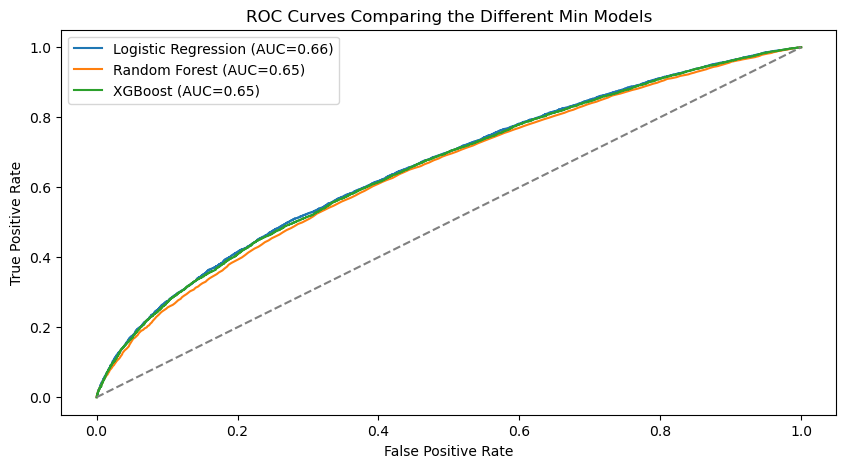

In [18]:
# Visualise ROC curves for min models
plt.figure(figsize=(10,5))
for name, model in min_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_min_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.2f})")

plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparing the Different Min Models')
plt.legend()
plt.show()

<Figure size 500x500 with 0 Axes>

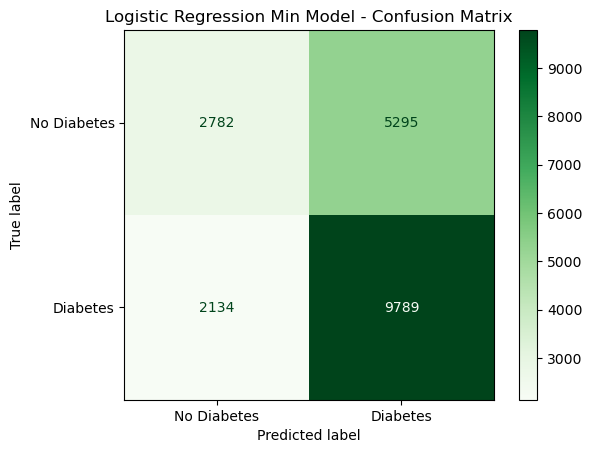

<Figure size 500x500 with 0 Axes>

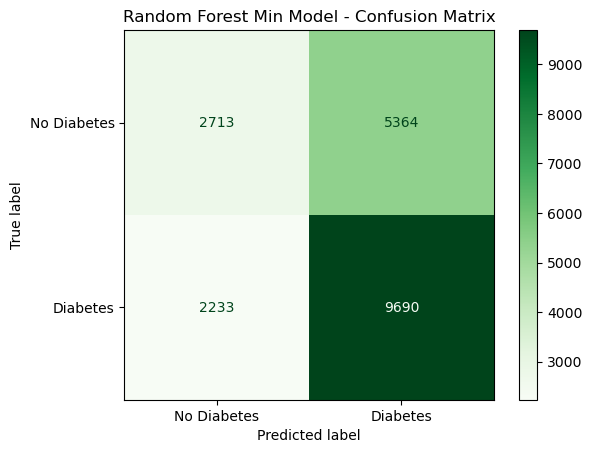

<Figure size 500x500 with 0 Axes>

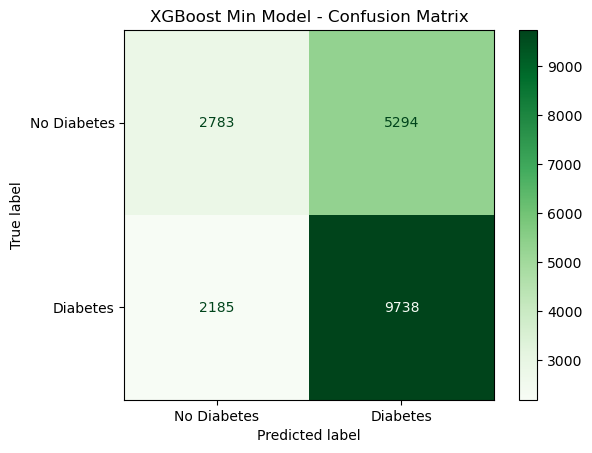

In [19]:
for model in min_model_results:
    cm = confusion_matrix(y_test, model['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes','Diabetes'])
    plt.figure(figsize=(5,5))
    disp.plot(cmap=plt.cm.Greens, values_format='d')
    plt.title(f'{model['name']} Min Model - Confusion Matrix')
    plt.show()

## Training max model

In [20]:
# Models list
max_models = {
    'Logistic Regression': LogisticRegression(max_iter=15000),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='auc'
    )
}

max_model_results = []

In [21]:
# Train, evaluate, and store metrics on max model
print("Max Model")
for name, model in max_models.items():
    model.fit(X_train_max_scaled, y_train)
    
    y_pred_max = model.predict(X_test_max_scaled)
    y_prob_max = model.predict_proba(X_test_max_scaled)[:,1]

    acc = accuracy_score(y_test, y_pred_max)
    prec = precision_score(y_test, y_pred_max)
    rec = recall_score(y_test, y_pred_max)
    f1s = f1_score(y_test, y_pred_max)
    roc = roc_auc_score(y_test, y_prob_max)

    max_model_results.append({
        'name': name,
        'y_pred': y_pred_max,
        'y_prob': y_prob_max,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1s,
        'roc_auc': roc
    })

    print(f"{name} — Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1s:.4f} | ROC-AUC: {roc:.4f}")

Max Model
Logistic Regression — Acc: 0.8548 | Prec: 0.8695 | Rec: 0.8900 | F1: 0.8796 | ROC-AUC: 0.9323
Random Forest — Acc: 0.9097 | Prec: 0.9992 | Rec: 0.8492 | F1: 0.9181 | ROC-AUC: 0.9394
XGBoost — Acc: 0.9093 | Prec: 0.9991 | Rec: 0.8487 | F1: 0.9178 | ROC-AUC: 0.9415


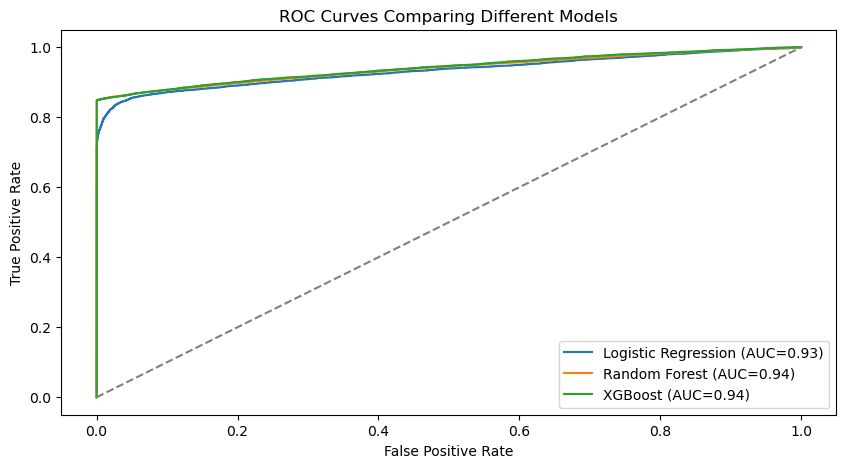

In [22]:
# Visualise ROC curves for models
plt.figure(figsize=(10,5))
for name, model in max_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_max_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.2f})")

plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparing Different Models')
plt.legend()
plt.show()

<Figure size 500x500 with 0 Axes>

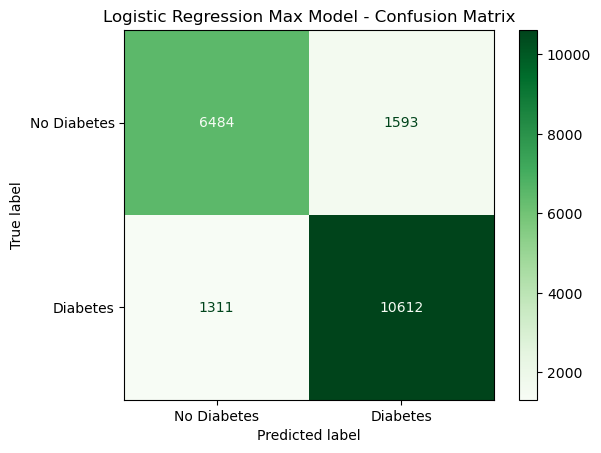

<Figure size 500x500 with 0 Axes>

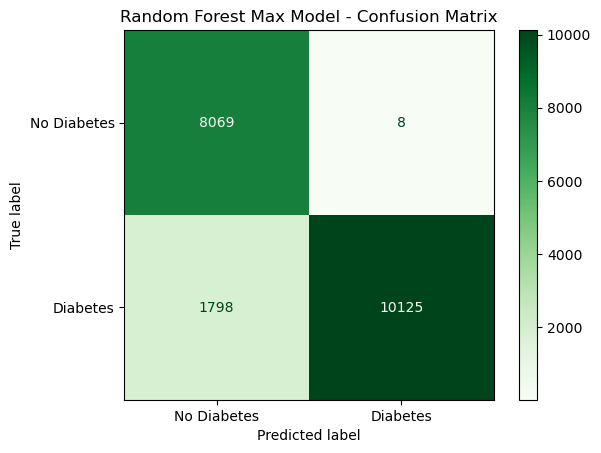

<Figure size 500x500 with 0 Axes>

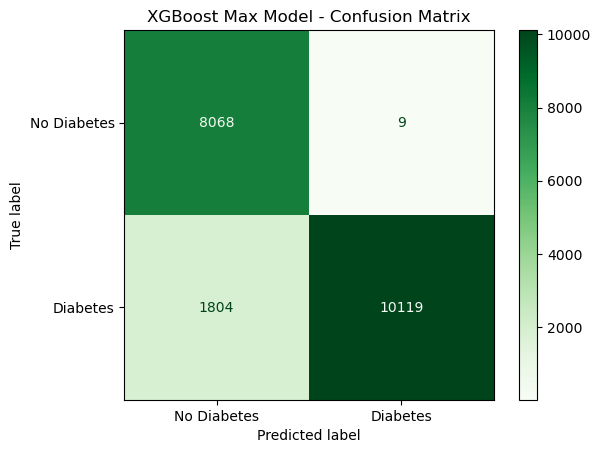

In [23]:
for model in max_model_results:
    cm = confusion_matrix(y_test, model['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes','Diabetes'])
    plt.figure(figsize=(5,5))
    disp.plot(cmap=plt.cm.Greens, values_format='d')
    plt.title(f'{model['name']} Max Model - Confusion Matrix')
    plt.show()

### Fine tuning Logistic Regression Min Model

In [24]:
# Hyperparameter grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l2", "l1"],
    "solver": ["liblinear", 'lbfgs'],
    "class_weight": [None, "balanced"]
}

lr_min = LogisticRegression(max_iter=5000)

grid_min = GridSearchCV(
    lr_min,
    param_grid,
    scoring="recall",   # optimize for recall
    cv=5,               # 5-fold cross-validation
    n_jobs=-1,          # use all CPU cores
    refit=True          # refit on full data using best params
)

grid_min.fit(X_train_min_scaled, y_train)

print("Best parameters for min model:", grid_min.best_params_)
print("Best recall for min model:", grid_min.best_score_)

C:\Users\saron\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\saron\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saron\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\saron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1193, in fit
    solver = 

Best parameters for min model: {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best recall for min model: 0.8694747789911595


Acc: 0.6277 | Prec: 0.6405 | Rec: 0.8559 | F1: 0.7327 | ROC-AUC: 0.6567


<Figure size 500x500 with 0 Axes>

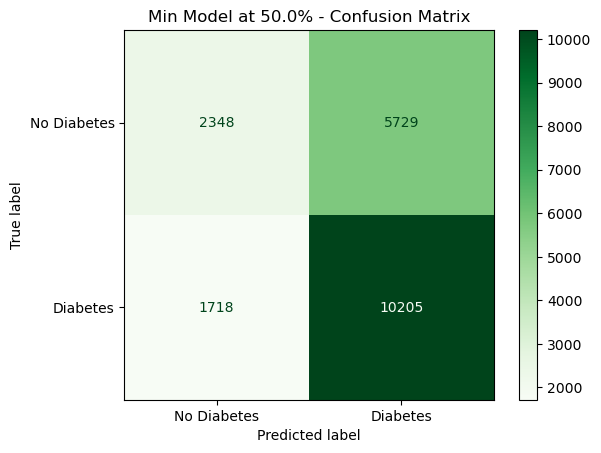

Acc: 0.6193 | Prec: 0.6194 | Rec: 0.9378 | F1: 0.7460 | ROC-AUC: 0.6567


<Figure size 500x500 with 0 Axes>

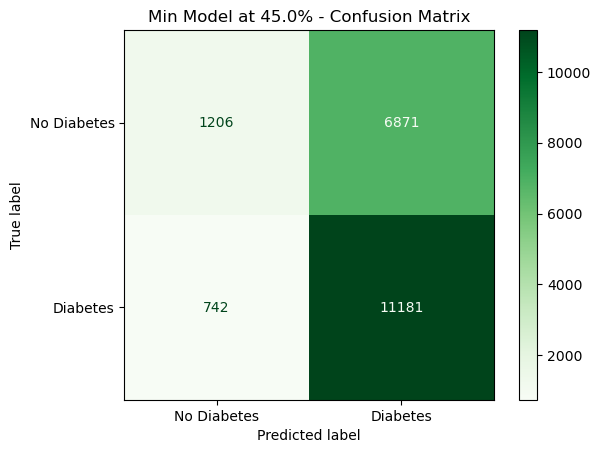

Acc: 0.6082 | Prec: 0.6061 | Rec: 0.9790 | F1: 0.7487 | ROC-AUC: 0.6567


<Figure size 500x500 with 0 Axes>

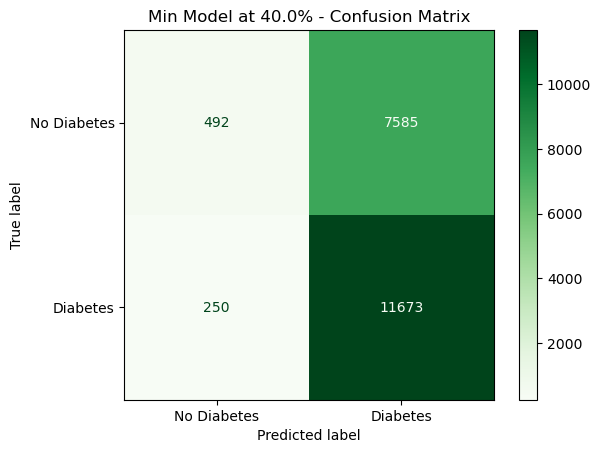

Acc: 0.6015 | Prec: 0.6001 | Rec: 0.9935 | F1: 0.7482 | ROC-AUC: 0.6567


<Figure size 500x500 with 0 Axes>

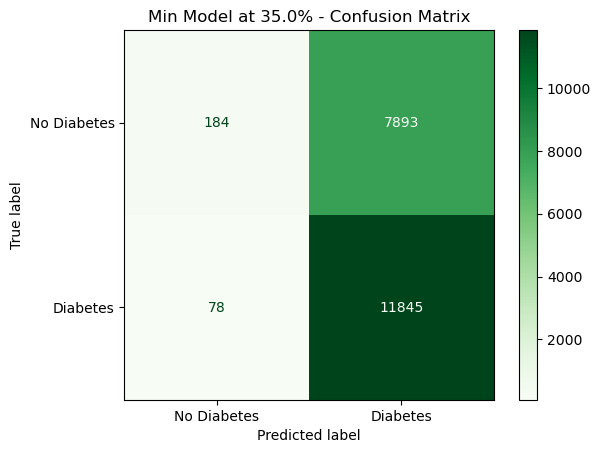

Acc: 0.5977 | Prec: 0.5972 | Rec: 0.9986 | F1: 0.7474 | ROC-AUC: 0.6567


<Figure size 500x500 with 0 Axes>

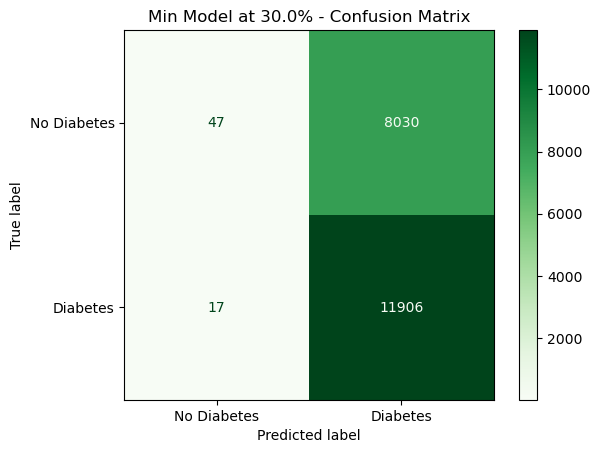

Acc: 0.5964 | Prec: 0.5963 | Rec: 0.9997 | F1: 0.7471 | ROC-AUC: 0.6567


<Figure size 500x500 with 0 Axes>

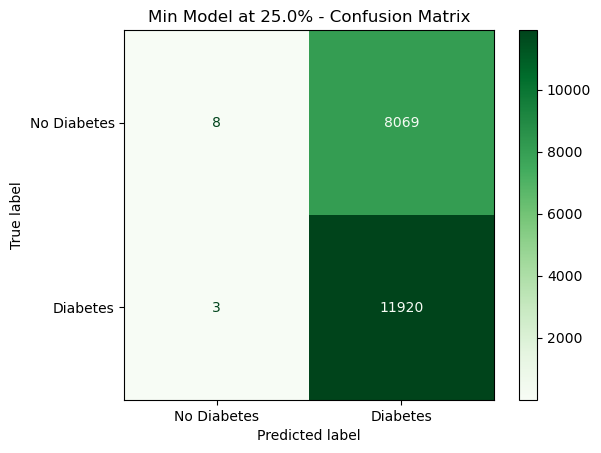

In [25]:
best_lr_min = grid_min.best_estimator_

# 2. Predict probabilities on test set
y_prob_min = best_lr_min.predict_proba(X_test_min_scaled)[:, 1]

# 3. Choose a threshold (or compute from recall curve)
thresholds = [0.5,0.45,0.4,0.35,0.3,0.25]

for threshold in thresholds:
    y_pred_min = (y_prob_min >= threshold).astype(int)
    
    # 4. Evaluate
    acc = accuracy_score(y_test, y_pred_min)
    prec = precision_score(y_test, y_pred_min)
    rec = recall_score(y_test, y_pred_min)
    f1s = f1_score(y_test, y_pred_min)
    roc = roc_auc_score(y_test, y_prob_min)
    print(f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1s:.4f} | ROC-AUC: {roc:.4f}")
    
    # 5. Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_min)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes','Diabetes'])
    plt.figure(figsize=(5,5))
    disp.plot(cmap=plt.cm.Greens, values_format='d')
    plt.title(f'Min Model at {threshold*100}% - Confusion Matrix')
    plt.show()


### Fine tuning Max Model

In [26]:
# Hyperparameter grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l2", "l1"],
    "solver": ["liblinear", 'lbfgs'],
    "class_weight": [None, "balanced"]
}

lr_max = LogisticRegression(max_iter=5000)

grid_max = GridSearchCV(
    lr_max,
    param_grid,
    scoring="recall",   # optimize for recall
    cv=5,               # 5-fold cross-validation
    n_jobs=-1,          # use all CPU cores
    refit=True          # refit on full data using best params
)

grid_max.fit(X_train_max_scaled, y_train)

print("Best parameters for max model:", grid_max.best_params_)
print("Best recall for max model:", grid_max.best_score_)

C:\Users\saron\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\saron\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saron\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\saron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1193, in fit
    solver = 

Best parameters for max model: {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best recall for max model: 0.8974102964118564


Acc: 0.8493 | Prec: 0.8596 | Rec: 0.8931 | F1: 0.8760 | ROC-AUC: 0.9320


<Figure size 500x500 with 0 Axes>

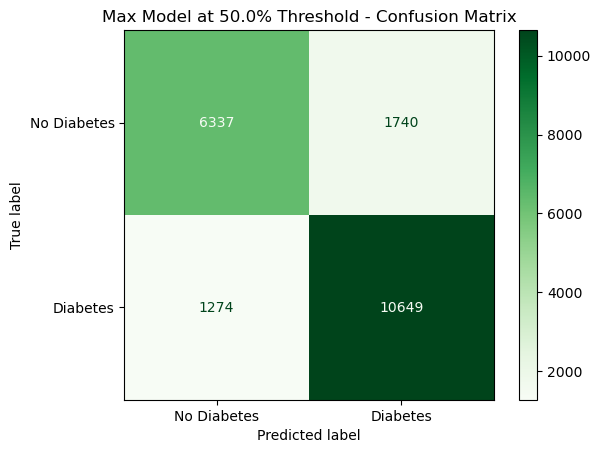

Acc: 0.8300 | Prec: 0.8257 | Rec: 0.9061 | F1: 0.8640 | ROC-AUC: 0.9320


<Figure size 500x500 with 0 Axes>

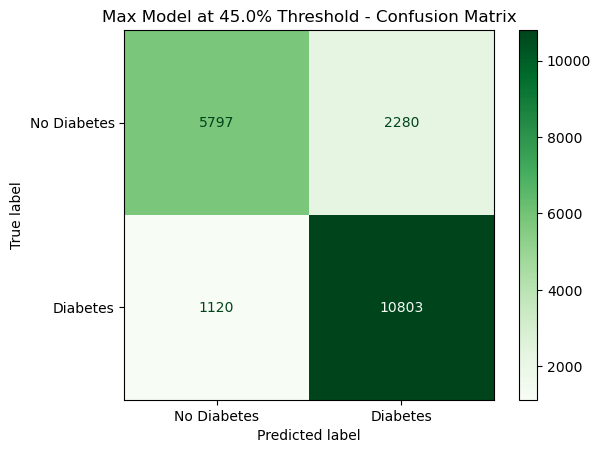

Acc: 0.8087 | Prec: 0.7940 | Rec: 0.9170 | F1: 0.8511 | ROC-AUC: 0.9320


<Figure size 500x500 with 0 Axes>

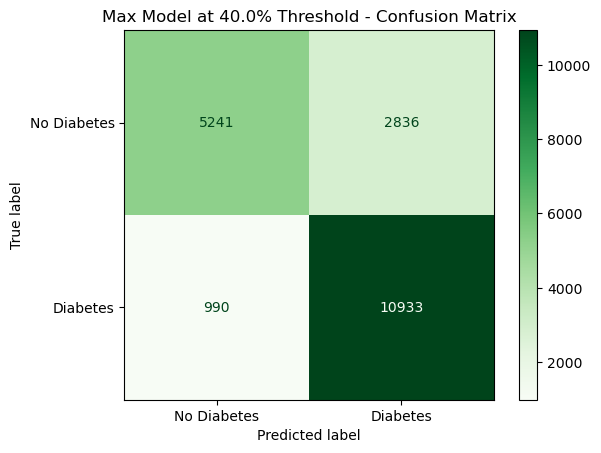

Acc: 0.7880 | Prec: 0.7661 | Rec: 0.9275 | F1: 0.8391 | ROC-AUC: 0.9320


<Figure size 500x500 with 0 Axes>

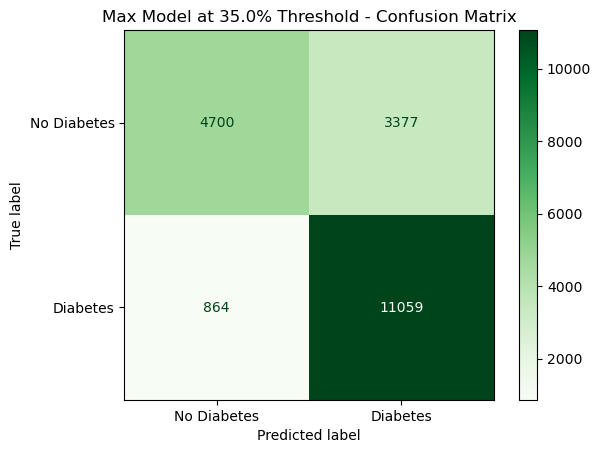

Acc: 0.7653 | Prec: 0.7391 | Rec: 0.9373 | F1: 0.8265 | ROC-AUC: 0.9320


<Figure size 500x500 with 0 Axes>

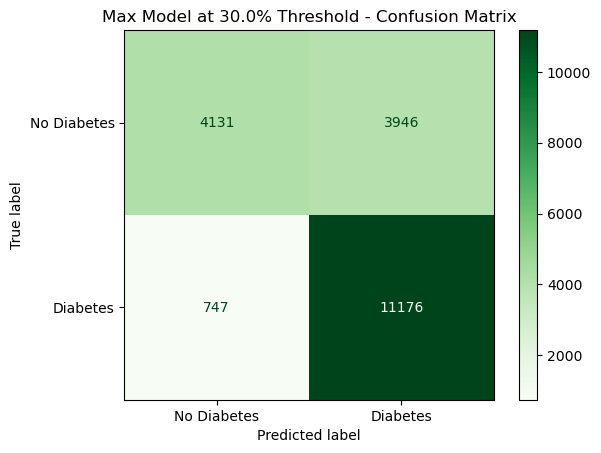

Acc: 0.7409 | Prec: 0.7134 | Rec: 0.9452 | F1: 0.8131 | ROC-AUC: 0.9320


<Figure size 500x500 with 0 Axes>

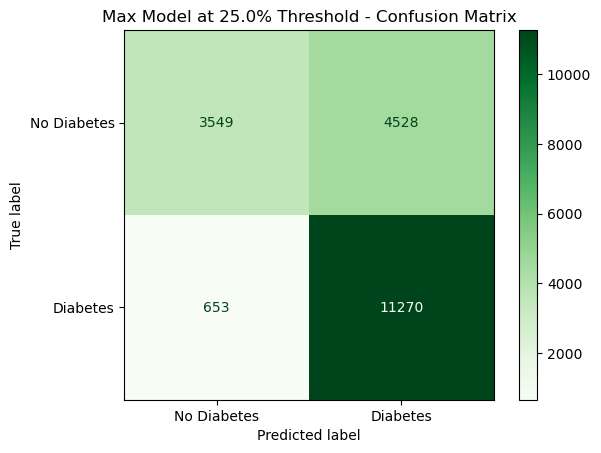

In [27]:
best_lr_max = grid_max.best_estimator_

# 2. Predict probabilities on test set
y_prob_max = best_lr_max.predict_proba(X_test_max_scaled)[:, 1]

# 3. Choose a threshold (or compute from recall curve)
thresholds = [0.5,0.45,0.4,0.35,0.3,0.25]

for threshold in thresholds:
    y_pred_max = (y_prob_max >= threshold).astype(int)
    
    # 4. Evaluate
    acc = accuracy_score(y_test, y_pred_max)
    prec = precision_score(y_test, y_pred_max)
    rec = recall_score(y_test, y_pred_max)
    f1s = f1_score(y_test, y_pred_max)
    roc = roc_auc_score(y_test, y_prob_max)
    print(f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1s:.4f} | ROC-AUC: {roc:.4f}")
    
    # 5. Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_max)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes','Diabetes'])
    plt.figure(figsize=(5,5))
    disp.plot(cmap=plt.cm.Greens, values_format='d')
    plt.title(f'Max Model at {threshold*100}% Threshold - Confusion Matrix')
    plt.show()

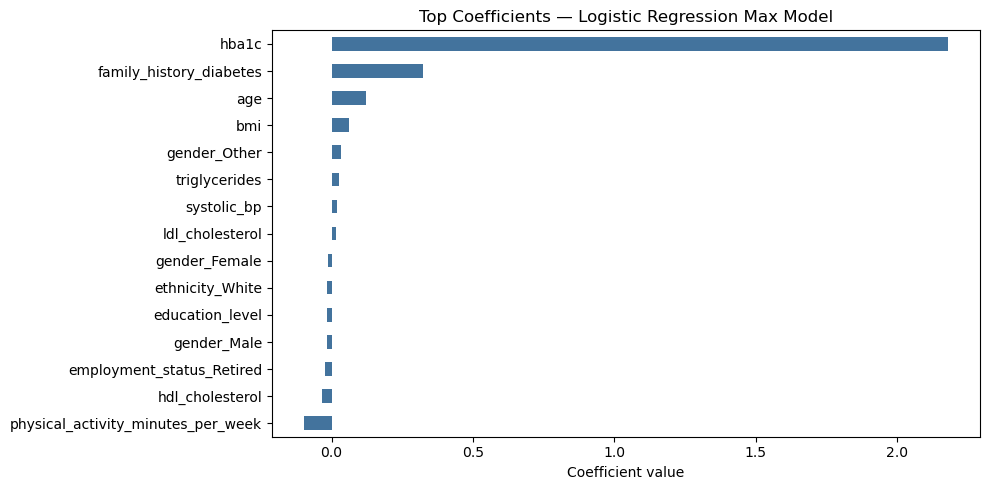

In [35]:
if hasattr(best_lr_max, 'feature_importances_'):
    importances = pd.Series(best_lr_max.feature_importances_, index=X_train_max_scaled.columns)
    top_feats = importances.sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    top_feats.sort_values().plot(kind='barh', color='blue')
    plt.title(f'Top Features — {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:  # Logistic Regression
    coefs = pd.Series(best_lr_max.coef_[0], index=X_train_max_scaled.columns).sort_values(key=abs, ascending=False).head(15)
    plt.figure(figsize=(10,5))
    coefs.sort_values().plot(kind='barh', color='#43739D')
    plt.title('Top Coefficients — Logistic Regression Max Model')
    plt.xlabel('Coefficient value')
    plt.tight_layout()
    plt.show()

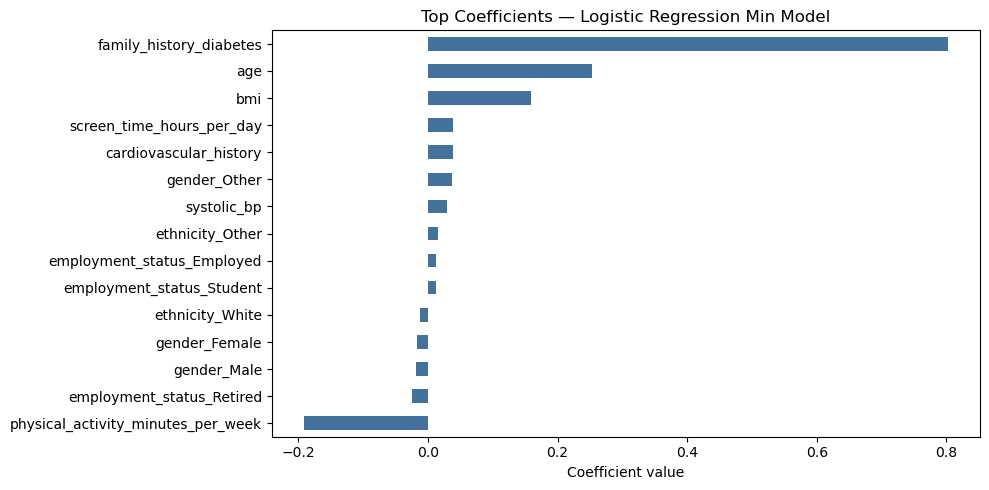

In [36]:
# Feature importance/coefficients
if hasattr(best_lr_min, 'feature_importances_'):
    importances = pd.Series(best_lr_max.feature_importances_, index=X_train_min_scaled.columns)
    top_feats = importances.sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    top_feats.sort_values().plot(kind='barh', color='#43739D')
    plt.title(f'Top Features — {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:  # Logistic Regression
    coefs = pd.Series(best_lr_min.coef_[0], index=X_train_min_scaled.columns).sort_values(key=abs, ascending=False).head(15)
    plt.figure(figsize=(10,5))
    coefs.sort_values().plot(kind='barh', color='#43739D')
    plt.title('Top Coefficients — Logistic Regression Min Model')
    plt.xlabel('Coefficient value')
    plt.tight_layout()
    plt.show()